# Python implementation

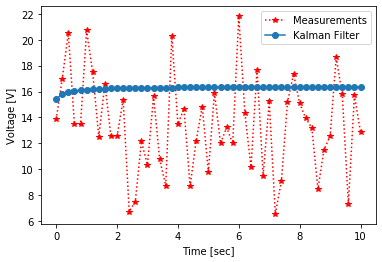

In [6]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

def GetVolt():
    w = 0 + 4*np.random.randn()
    z = 14.4 + w
    return z
    
def SimpleKalman(z):
    A = np.matrix('[1]')
    H = np.matrix('[1]')  
    Q = np.matrix('[0]')
    R = np.matrix('[4]')
    x = np.matrix('[14]')
    P = np.matrix('[6]')
    while True:
        xp = A * x
        Pp = A * P * A.getT() + Q
        K = Pp * H.getT() * np.matrix.getI(H * Pp * H.getT() + R)
        x = xp + K * (z - H * xp)
        P = Pp - K * H * Pp
        volt = x
        yield volt

dt = 0.2
t  = np.arange(0, 10+dt, dt)

Nsamples = len(t)

Xsaved = np.zeros(Nsamples)
Zsaved = np.zeros(Nsamples)
volt = SimpleKalman(GetVolt())

for k in range(Nsamples):
    z = GetVolt()
    Xsaved[k] = next(volt)
    Zsaved[k] = z

fig, ax = plt.subplots()
ax.plot(t, Zsaved, 'r:*', label="Measurements")
ax.plot(t, Xsaved, 'o-', label="Kalman Filter") 
plt.xlabel("Time [sec]")
plt.ylabel("Voltage [V]")
plt.legend()

# DPC++ implementation

In [1]:
%%writefile SimpleKalman.cpp
#include <iostream>
#include <fstream>
#include <stdlib.h>
#include <stdio.h>
#include <limits>
#include <random>
#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"

namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;
using namespace std;

float GetVolt(float rn) {
    float w = 0 + 4*rn;
    float z = 14.4 + w;
    return z;
}

void inv(sycl::queue &queue, float *A, int64_t N);
void eye(size_t N,float *A, float alpha);
void display(size_t rF, size_t cS, float *matrix);
void zero(size_t n, size_t m, float *C);

int main(){
    ofstream myfile("SimpleKalman.csv");
    myfile << "Time,Measurements,Kalman\n";
    auto async_handler = [](sycl::exception_list exceptions) {
        for (exception_ptr const &e : exceptions) {
            try {
                rethrow_exception(e);
            }
            catch (sycl::exception const &e) {
                cout << "Caught asynchronous SYCL exception: " << e.what() << endl;
            }
        }
    };
    try {
        constexpr int N = 1;
        default_random_engine generator;
        generator.seed(42);
        normal_distribution<float> distribution(0.0, 1.0);

        auto nontransM = oneapi::mkl::transpose::nontrans;
        auto transM = oneapi::mkl::transpose::trans;
        float alpha = 1.0; float beta = 0.0;

        sycl::device device = sycl::device(sycl::default_selector());
        cout << "Device: " << device.get_info<sycl::info::device::name>() << "\n";
        sycl::queue queue(device, async_handler);
        vector<sycl::event> event_list;

        float dt = 0.2, first = 0.0, volt;
        int Nsamples = 51;
        float t[Nsamples];
        
        float *A = sycl::malloc_shared<float>(1, queue); A[0] = 1.0;
        float *H = sycl::malloc_shared<float>(1, queue); H[0] = 1.0;
        float *Q = sycl::malloc_shared<float>(1, queue); Q[0] = 0.0;
        float *R = sycl::malloc_shared<float>(1, queue); R[0] = 4.0;
        float *x = sycl::malloc_shared<float>(1, queue); x[0] = 14.0;
        float *P = sycl::malloc_shared<float>(1, queue); P[0] = 6.0;
        float *z = sycl::malloc_shared<float>(1, queue);      
        
        float *xp = sycl::malloc_shared<float>(1, queue);
        float *Pp = sycl::malloc_shared<float>(1, queue);
        float *K = sycl::malloc_shared<float>(1, queue);
        float *AP = sycl::malloc_shared<float>(1, queue);
        float *PpHT = sycl::malloc_shared<float>(1, queue);
        float *HpHTR = sycl::malloc_shared<float>(1, queue);
        float *Hxp = sycl::malloc_shared<float>(1, queue);
        float *Kz = sycl::malloc_shared<float>(1, queue);
        float *KH = sycl::malloc_shared<float>(1, queue);
        
        auto *Xsaved = sycl::malloc_shared<float>(Nsamples, queue);
        auto *Zsaved = sycl::malloc_shared<float>(Nsamples, queue);
        if (!Xsaved || !Zsaved) {
            cerr << "Could not allocate memory for vectors." << endl;
            exit(1);
        }
        
        for (int i = 0; i < Nsamples; i++) {
            constexpr int gemm_total = 10, axpy_total = 5;
            sycl::event gemm_task[gemm_total], scal_task;
            sycl::event axpy_task[axpy_total];
            vector<sycl::event> gemm[gemm_total];
            
            t[i] = first;
            first += dt;
            Zsaved[i] = z[0] = GetVolt(distribution(generator));
            
            // xp = A * x
            gemm_task[0] = blas::gemm(queue, nontransM, nontransM, 1, 1, 1, alpha, A, 1, x, 1, beta, xp, 1, gemm[0]);
            gemm_task[0].wait();
            // Pp = A * P * A' + Q
                //1.1) AP = A * P
            gemm_task[1] = blas::gemm(queue, nontransM, nontransM, 1, 1, 1, alpha, A, 1, P, 1, beta, AP, 1,gemm[1]);
            gemm_task[1].wait();           
                //1.2) Pp = AP * A'
            gemm_task[2] = blas::gemm(queue, nontransM, transM, 1, 1, 1, alpha, AP, 1, A, 1, beta, Pp, 1, gemm[2]);
            gemm_task[2].wait();
                //1.3)Pp = Pp + Q
            axpy_task[0] = blas::axpy(queue, 1, alpha, Q, 1.0, Pp, 1.0);
            axpy_task[0].wait();
            // K = Pp * H' * inv(H * Pp * H' + R)
                //2.1) PpHT = Pp * H' -->  dimensao PpHT: (M * N)
            gemm_task[3] = blas::gemm(queue, nontransM, transM, 1, 1, 1, alpha, Pp, 1, H, 1, beta, PpHT, 1, gemm[3]);
            gemm_task[3].wait();
                //2.2) HpHTR = H * (Pp * H') = H (NxM) * PpHT(MxN) --> HpHTR (NxN)
            gemm_task[4] = blas::gemm(queue, nontransM, nontransM, 1, 1, 1, alpha, H, 1, PpHT, 1, beta, HpHTR, 1,gemm[4]);
            gemm_task[4].wait();
                // 2.3) HpHTR = HpHTR + R
            axpy_task[1] = blas::axpy(queue, 1, alpha, R, 1.0, HpHTR, 1.0);
            axpy_task[1].wait();
            // HpHTR = inv(HpHTR)
            inv(queue, HpHTR, 1);
                // 2.4) K = (Pp * H') * HpHTR ==> PpHT(MxN) * HpHTR(NxN) ---> K(MxN)
            gemm_task[5] = blas::gemm(queue, nontransM, nontransM, 1, 1, 1, alpha, PpHT, 1, HpHTR, 1, beta, K, 1,gemm[5]);
            gemm_task[5].wait();
            // x = xp + K * (z - H * xp)          
                //3.1) Hxp = H(NxM) * xp(MxN) --> Hxp(NxN)
            gemm_task[6] = blas::gemm(queue, nontransM, nontransM, 1, 1, 1, alpha, H, 1, xp, 1, beta, Hxp, 1, gemm[6]);
            gemm_task[6].wait();
                //3.2) z = -Hxp(NxN) + z(NxN)
            axpy_task[2] = blas::axpy(queue, 1, -alpha, Hxp, 1.0, z, 1.0);
            axpy_task[2].wait();
                //3.3) Kz = K*z --> Kz(MxN)
            gemm_task[7] = blas::gemm(queue, nontransM, nontransM, 1, 1, 1, alpha, K, 1, z, 1, beta, Kz, 1, gemm[7]);
            gemm_task[7].wait();
                //3.4) xp = xp + Kz //fix-me
            x[0] = xp[0]; 
            axpy_task[3] = blas::axpy(queue, 1, alpha, Kz, 1.0, x, 1.0);
            axpy_task[3].wait();
                //3.5 x = ???
            // P = Pp - K * H * Pp
                //4.1) KH = K(MxN)*H(NxM) 
            gemm_task[8] = blas::gemm(queue, nontransM, nontransM, 1, 1, 1, alpha, K, 1, H, 1, beta, KH, 1, gemm[8]);
            gemm_task[8].wait();
                //4.2) P = KH(MxM) * Pp(MxM)
            gemm_task[9] = blas::gemm(queue, nontransM, nontransM, 1, 1, 1, alpha, KH, 1, Pp,1, beta, P, 1, gemm[9]);
            gemm_task[9].wait();
                //4.3) P = (-Pp + P)
            axpy_task[4] = blas::axpy(queue, 1, -alpha, Pp, 1.0, P, 1.0);
            axpy_task[4].wait();
                //4.4) P = -P
            scal_task = blas::scal(queue, 1, -alpha, P, 1.0);
            scal_task.wait();
            Xsaved[i] = x[0];
            myfile << t[i] << ", " << Zsaved[i] << ", " << Xsaved[i] << '\n';
        }

        free(Xsaved, queue);
        free(Zsaved, queue);

        free(A, queue);
        free(H, queue);
        free(Q, queue);
        free(R, queue);
        free(x, queue);
        free(P, queue);
        free(z, queue);
        
        free(xp, queue);
        free(Pp, queue);
        free(K, queue);
        free(AP, queue);
        free(PpHT, queue);
        free(HpHTR, queue);
        free(Hxp, queue);
        free(Kz, queue);
        free(KH, queue);
        myfile.close();

    } catch (const exception &e) {
        cerr << "An exception occurred: "
                  << e.what() << endl;
        exit(1);
    }
}

void inv(sycl::queue &queue, float *A, int64_t N) {
    sycl::event getr_task[2];
    vector<sycl::event> event_list;

    float scratch_size = lapack::getrf_scratchpad_size<float>(queue, N, N, N);
    float *scratchpad = sycl::malloc_shared<float>(scratch_size+1, queue);

    auto *IPIV = sycl::malloc_shared<int64_t>(N*N, queue);
    
    getr_task[0] = lapack::getrf(queue, N, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[0].wait();
    getr_task[1] = lapack::getri(queue, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[1].wait();
    
    free(IPIV, queue);
}

Overwriting SimpleKalman.cpp


# CPU execution

dpcpp SimpleKalman.cpp -o SimpleKalman -DMKL_ILP64  -I"/glob/development-tools/versions/oneapi/2021.3/inteloneapi/mkl/2021.3.0/include" -fsycl-device-code-split=per_kernel -L/glob/development-tools/versions/oneapi/2021.3/inteloneapi/mkl/2021.3.0/lib/intel64 -lmkl_sycl -lmkl_intel_ilp64 -lmkl_sequential -lmkl_core -lsycl -lOpenCL -lpthread -lm -ldl
./SimpleKalman
Device: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz


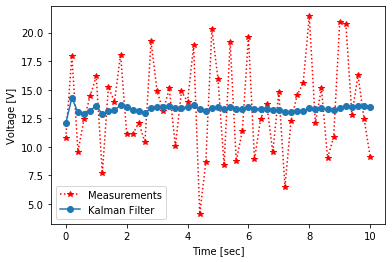

In [2]:
! make 
! mv SimpleKalman.csv SimpleKalmanCPU.csv

import matplotlib.pyplot as plt
import pandas as pd

def plot_results(filename):
    df = pd.read_csv(filename)
    fig, ax = plt.subplots()
    ax.plot(df.Time.to_list(), df.Measurements.to_list(), 'r:*', label="Measurements")
    ax.plot(df.Time.to_list(), df.Kalman.to_list(), 'o-', label="Kalman Filter") 
    plt.xlabel("Time [sec]")
    plt.ylabel("Voltage [V]")
    plt.legend()

plot_results('SimpleKalmanCPU.csv')

# GPU execution

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
939765.v-qsvr-1            ...ub-singleuser u44807          00:00:12 R jupyterhub     
939772.v-qsvr-1            build_run.sh     u44807                 0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (build_run.sh.o939772)

 Done⬇

########################################################################
#      Date:           Fri 06 Aug 2021 05:52:47 AM PDT
#    Job ID:           939772.v-qsvr-1.aidevcloud
#      User:           u44807
# Resources:           neednodes=1:gpu:ppn=2,nodes=1

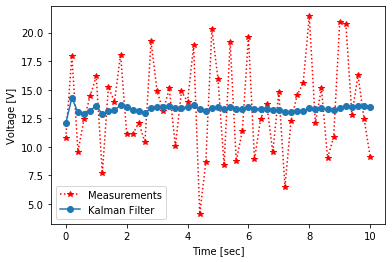

In [3]:
! chmod 755 q; chmod 755 build_run.sh; if [ -x "$(command -v qsub)" ]; then ./q build_run.sh; else ./build_run.sh; fi
! mv SimpleKalman.csv SimpleKalmanGPU.csv

plot_results('SimpleKalmanGPU.csv')